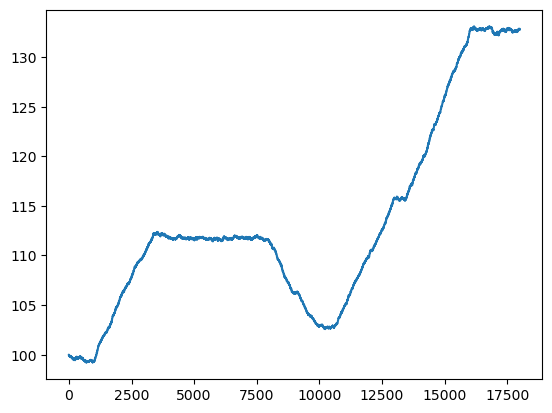

In [248]:
import numpy as np
import time
from scipy.stats import norm
from typing import Type, Union
import matplotlib.pyplot as plt

dt=1

class DriftSwitchIndex3:

    def __init__(self, vol, drift, S0, T) -> None:
        """
        Initialisation of Drift Switch Index

        :param vol: float
            Index volatility
        :param drift : float
            Index drift
        :param S0: float
            Index initial value
        :param T: float
            Characteristic time of regimes
        """
        self.vol = vol
        self.drift = drift 
        self.S0 = S0
        self.T = T
        self.P = self.prob_matrix(T)

    def gamma(self, dt: float = dt):
        """
        Gamma coefficient formula

        Parameters
        ----------
        dt : float
            Time lapse between two steps in the stochastic process.

        Returns 
        -------
        gamma : float
            The value of gamma
        """

        l = 1 / self.T
        drift = self.drift
        x_p = (l * np.exp(drift*dt)) / (1 - np.exp(drift*dt)*(1-l)) - 1
        x_m = (l * np.exp(-drift*dt)) / (1 - np.exp(-drift*dt)*(1-l)) - 1
        a_p0 = (- 2 * x_m - x_p * (1+x_m)) / (x_p - x_m)
        return a_p0

    def prob_matrix(self,T) -> np.array:
        """
        Transition matrix initialisation (Markov)

        Parameters
        ----------
        T : float
            Characteristic time of regimes

        Returns 
        -------
        P : np.array()
            Probability matrix 
        """
        g = self.gamma()
        P = np.zeros((3,3))
        l = 1 / T
        P[:,0] = np.array([1 - l, l/2, l/2])
        P[:,1] = np.array([(1 - g) * l, 1 - l, g * l])
        P[:,2] = np.array([l/2, l/2, 1 - l])
        return P
    


    def one_d_regime_generation(self,n) -> np.array:
        """
        Generate a 1D array of n values of regimes between -1, 0 and 1

        Parameters
        ----------
        n : int
            The number of timesteps

        Returns 
        -------
        mu : np.array()
            The array of regimes
        """
        
        # Generate the durations of the regimes
        regimes_durations, k = [], 0
        while k < n :
            t = np.random.geometric(1/self.T)
            k += t
            regimes_durations.append(t)
        regimes_durations[-1] -= k-n
        regimes_begin = np.concatenate([np.zeros(1),np.cumsum(regimes_durations)[:-1]])
        s = len(regimes_durations)

        # Generate the alternance of the regimes (of duration 1)
        regimes_list, cur_regime = [], 1
        transitions = np.array([np.empty(s),np.empty(s),np.empty(s)],dtype=int)
        for i in [0,1,2]:
            trans_prob = self.P[i]
            trans_prob[i] = 0
            trans_prob /= sum(trans_prob)
            transitions[i] = np.random.choice([0,1,2],p=trans_prob,size=s)
        for i in range(s):
            regimes_list.append(cur_regime-1)
            cur_regime = transitions[cur_regime][i]

        # Generate the final array of regimes with the good durations
        mu = np.empty(n)
        for i,regime in enumerate(regimes_list):
            t = int(regimes_begin[i])
            mu[t:t+regimes_durations[i]] = np.full(regimes_durations[i],regime)
        return mu
    


    
    def regime_generation(self, size) -> np.ndarray:
        """
        Generate an array / several arrays of regimes between -1, 0 and 1 

        Parameters
        ----------
        size : int or pair
            The number of timesteps

        Returns 
        -------
        result : np.array() or np.ndarray()
            The array of regimes
        """
        if type(size) == int :
            return self.one_d_regime_generation(size)
        (k,n) = size
        result = np.empty(size)
        for i in range(k):
            result[i] = self.one_d_regime_generation(n)
        return result


    def returns(self, dt: float = dt,
                size: Union[int, tuple[int]] = 1,
                seed: int = None) -> np.ndarray:
        """
        Generate step returns based on the stochastic process parameters.

        Parameters
        ----------
        dt : float, optional
            Time lapse between two steps in the stochastic process.
            Default is dt.
        size : int or tuple of int, optional
            Size of the array with rows and columns corresponding respectively
            to the different paths and steps of the stochastic process.
            Default is 1.
        seed : None or int
            The seed of the random generator. Default is None

        Returns
        -------
        np.ndarray
            Array of step returns based on the specified parameters.
        """

        x = norm.rvs(loc=0,scale=1,size=size, random_state=seed)
        regime = self.regime_generation(size)
        log_ratio = (regime * self.drift - 0.5 * self.vol ** 2) * dt + self.vol * x * np.sqrt(dt)  
        if type(size) == int :
            feed = self.S0 * np.exp(np.cumsum(log_ratio))
        else :
            feed = self.S0 * np.exp(np.cumsum(log_ratio,axis = 1))
        return feed

myIndex = DriftSwitchIndex3(vol=0.00015, drift=0.00005, S0=100, T=1800)
spot = myIndex.returns(size=18000)

plt.plot(spot)
plt.show()


In [251]:
type(np.array([[1,1],[1,1]]))

numpy.ndarray